Jaccard Similarity matrices and heatmaps have been generated and saved.


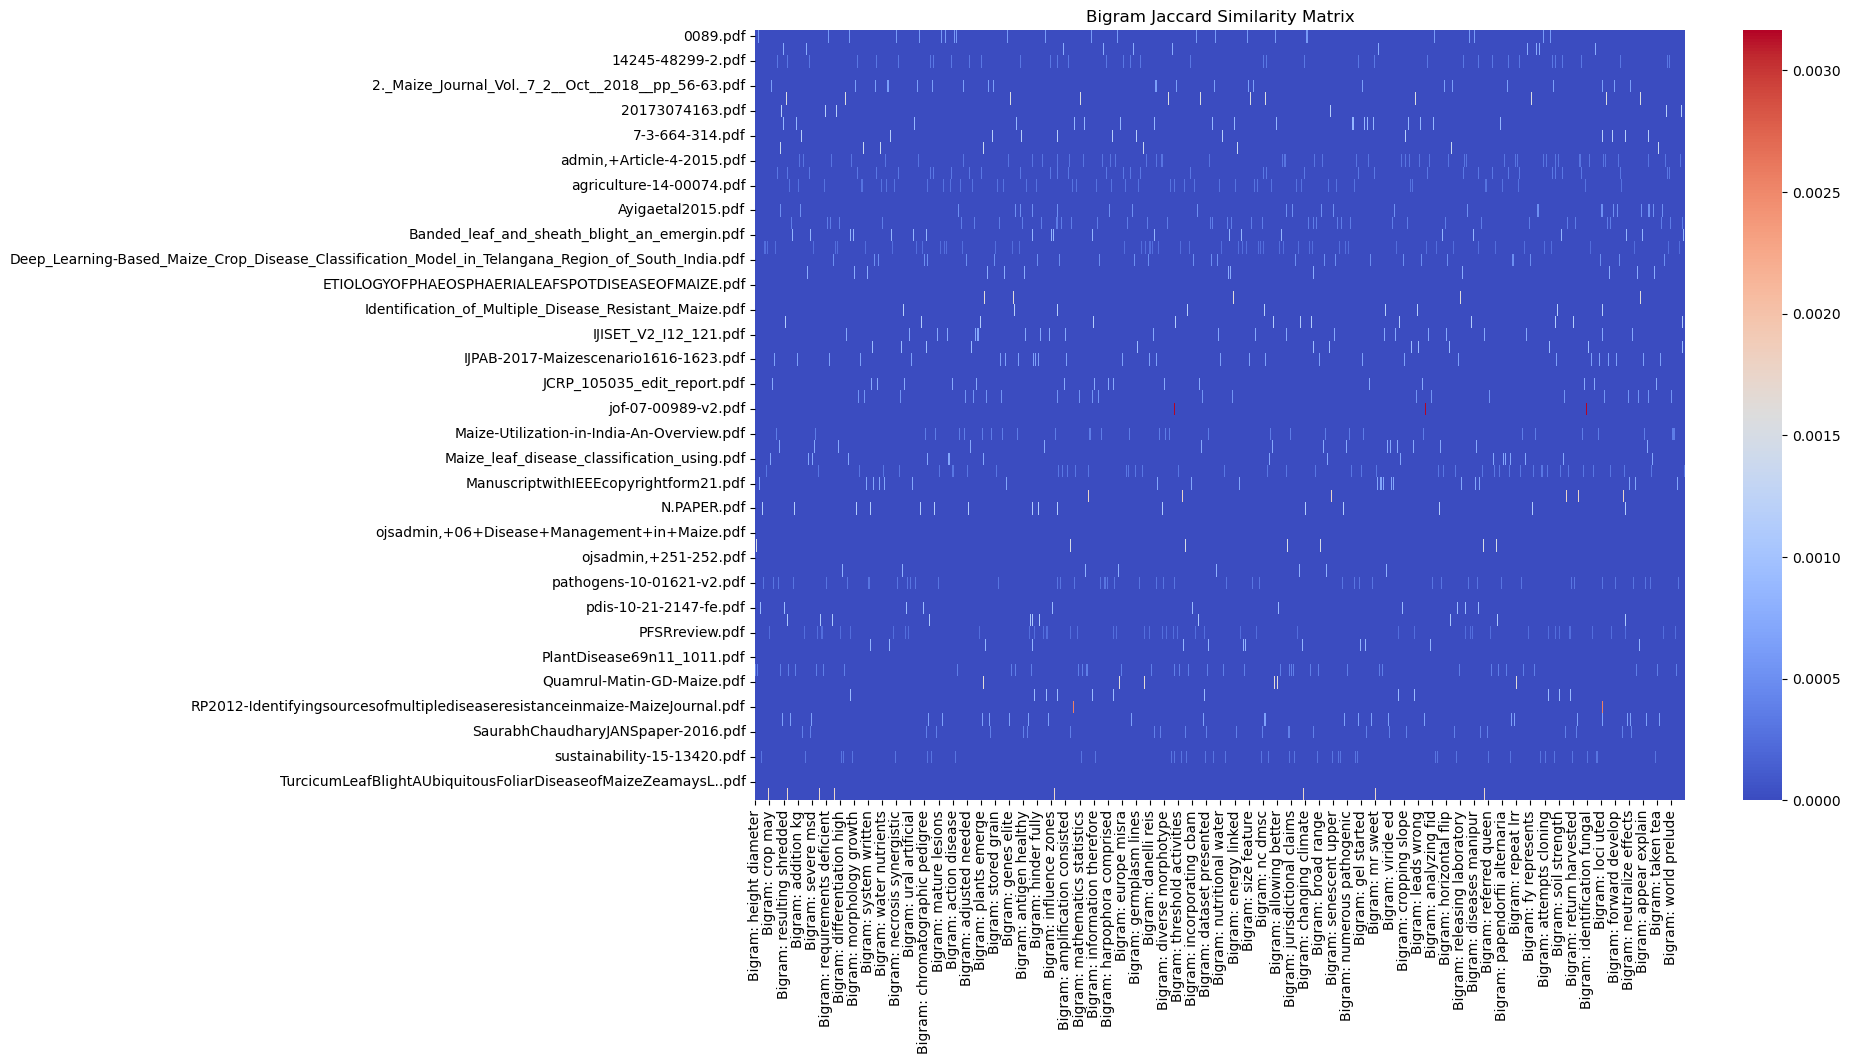

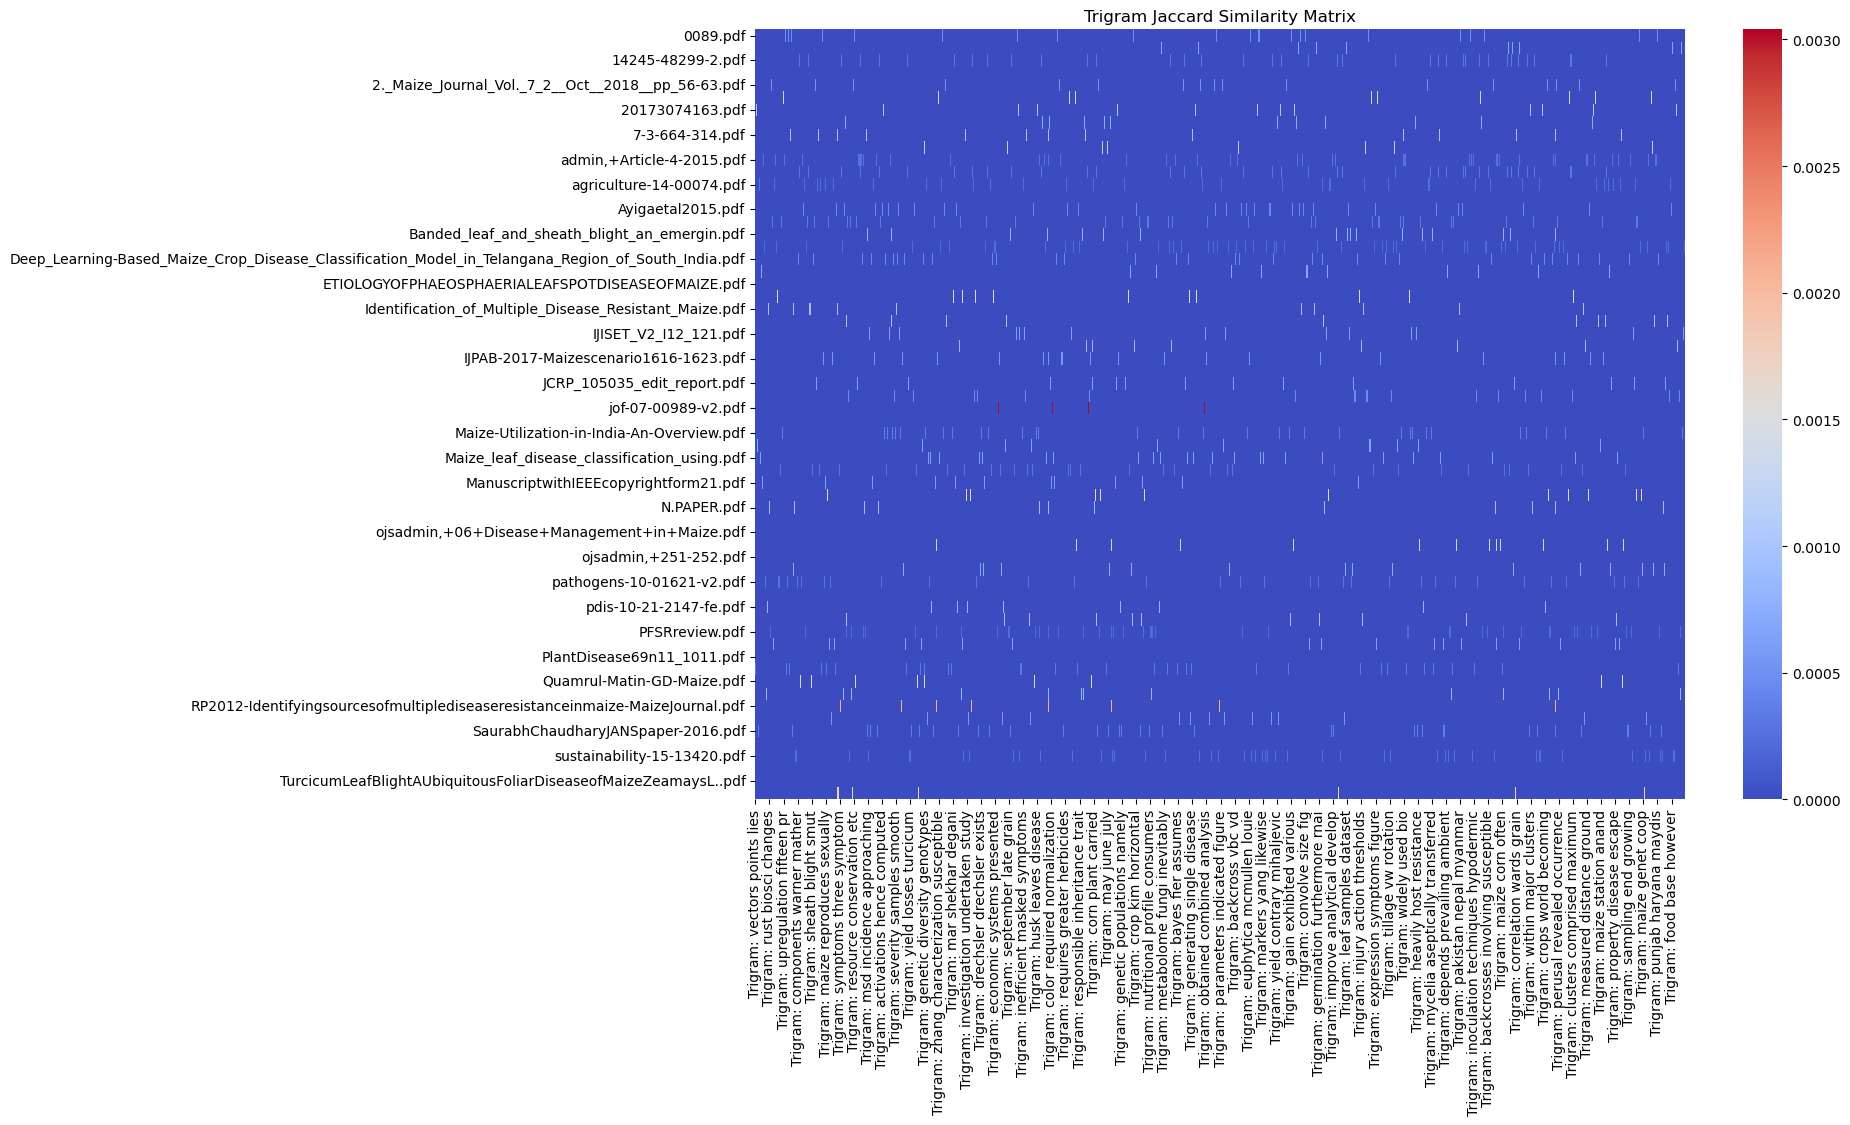

In [6]:
import os
import pandas as pd
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
import fitz
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Function to extract relevant text (abstract to references)
def extract_relevant_text(pdf_file):
    doc = fitz.open(pdf_file)
    text = ""
    capture = False
    for page in doc:
        page_text = page.get_text()
        if "abstract" in page_text.lower():
            capture = True
        if "references" in page_text.lower():
            capture = False
        if capture:
            text += page_text + " "
    return text.lower()

# Set input and output folder paths
input_folder = "m_t_s_n_m/"
output_folder = "output911"
os.makedirs(output_folder, exist_ok=True)

# Define stop words, stemmer, lemmatizer, and unwanted words
stop_words = set(stopwords.words('english'))
unwanted_words = {
    'article', 'et', 'al', 'terms', 'conditions', 'publication', 'cititation', 'open', 'access', 'license', 
    'cc', 'by', 'creative', 'commons', 'attribution', 'proposed', 'original', 'generated', 'images', 'image', 
    'generation', 'learning', 'rate', 'function', 'map', 'classification', 'ns', "effect", "using", "based", "observed", 
    "showed", "response", "found", "among", "years", "data", "level", "value", "well", "many", "caused", "compared", 
    "associated", "significant", "models", "results", "studies", "methods", "input", "performance", "improvement", "comparison", 
    "research", "model", "cluster", "the", "and", "also", "table", "normal", "one", "two", "four", "showed", "g", "level", "found",
    "c", "x", "xm", "b", "r", "e", "f", "g", "h", "j", "lwd", "sp", "t", "z","s", "v", "l", "n", "x", "b", "x", "b", "y", "v", "q", 
    "shown", "method", "state", "j", "date", "plot", "trials", "per", "cent", "new", "delhi","hki", "hki", "r", "h", "south", "africa", 
    "united", "states", "b", "b", "also", "reported", "network", "support", "e", "india", "present", "iii", "iv", "v", "iii", "iv", "v", 
    "vi", "authorized", "licensed", "use", "limited", "licensed", "limited", "walchand", "use", "limited", "walchand", "college", "limited", 
    "walchand", "college", "eng", "walchand", "college", "eng", "downloaded", "college", "eng", "downloaded", "february", "eng", "downloaded", 
    "february", "utc", "downloaded", "february", "utc", "ieee", "february", "utc", "ieee", "xplore", "utc", "ieee", "xplore", "restrictions",  
    "ieee", "xplore", "hyd", "hyd", "hyd", "hyd","institute", "new", "different", "process", "int", "pure",  "app", "control", "research", 
    "institute", "new", "delhi",  "agrinula", "jurnal", "agroteknologi", "dan", "jurnal", "agroteknologi", "dan", "perkebunan", 
    "agroteknologi", "dan", "perkebunan",  "american", "journal", "development", "ls", "smo", "udaipur", "wdr", "rajasthan", "e", 
    "loam","campus",  "new","length", "number", "rows", "asr", "gsr", "sr", "ijiset", "international", "journal", "innovative", 
    "science", "engineering", "technology", "vol", "issue ", "december ", "issn ", "singh", "int ", "issn", "copyright", "ijpab", "average", 
    "c", "c",  "anonymous ", "maurit ", "sug ", "ind ", "maurit ", "sug ", "ind ", "res ", "ta ", "days",  "si ", "days ", "ph  b", 
    "silking", "ph", "eh ",  "eh ", "epp ", "epp ", "ears ", "per ", "ears ", "el ", "eg ",  "krp", "rows", "per"
}

# Function to generate n-grams
def generate_ngrams(tokens, n):
    return list(ngrams(tokens, n))

# Function to write top 200 n-grams to a text file
def write_top_ngrams_to_file(file_path, ngram_counts, n):
    top_ngrams = ngram_counts.most_common(200)  # Get the top 200 n-grams based on frequency
    with open(file_path, "w", encoding="utf-8") as file:
        for ngram, count in top_ngrams:
            file.write(f"{' '.join(ngram)}\n")

# Function to read n-grams from a file
def read_top_ngrams_from_file(file_path):
    top_ngrams = []
    with open(file_path, "r", encoding="utf-8") as file:
        lines = file.readlines()
        for line in lines:
            line = line.strip()
            if line:  # Ignore empty lines
                ngram = tuple(line.split())
                top_ngrams.append(ngram)
    return top_ngrams

# Initialize counters for bigrams and trigrams
bigram_counts = Counter()
trigram_counts = Counter()
all_bigrams = set()
all_trigrams = set()

# Process each PDF file in the input folder
papers = []
for file_name in os.listdir(input_folder):
    if file_name.endswith(".pdf"):
        pdf_path = os.path.join(input_folder, file_name)
        raw_text = extract_relevant_text(pdf_path)
        tokens = word_tokenize(raw_text)
        tokens = [word for word in tokens if word.isalpha() and word not in stop_words and word not in unwanted_words]

        # Generate bigrams and trigrams for the paper
        bigrams = generate_ngrams(tokens, 2)
        trigrams = generate_ngrams(tokens, 3)

        all_bigrams.update(bigrams)
        all_trigrams.update(trigrams)

        papers.append(file_name)

# Create a set of non-redundant n-grams
non_redundant_bigrams = set(all_bigrams)
non_redundant_trigrams = set(all_trigrams)

# Calculate Jaccard similarity for each paper and each n-gram (bigram/trigram)
jaccard_matrix_bigrams = []
jaccard_matrix_trigrams = []

for file_name in papers:
    pdf_path = os.path.join(input_folder, file_name)
    raw_text = extract_relevant_text(pdf_path)
    tokens = word_tokenize(raw_text)
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words and word not in unwanted_words]

    bigrams = set(generate_ngrams(tokens, 2))
    trigrams = set(generate_ngrams(tokens, 3))

    # Jaccard similarity for bigrams
    jaccard_bigrams = [jaccard_similarity(bigrams, {ngram}) for ngram in non_redundant_bigrams]
    jaccard_trigrams = [jaccard_similarity(trigrams, {ngram}) for ngram in non_redundant_trigrams]

    jaccard_matrix_bigrams.append(jaccard_bigrams)
    jaccard_matrix_trigrams.append(jaccard_trigrams)

# Convert Jaccard matrices into DataFrames
bigram_jaccard_df = pd.DataFrame(jaccard_matrix_bigrams, columns=[f'Bigram: {" ".join(ngram)}' for ngram in non_redundant_bigrams], index=papers)
trigram_jaccard_df = pd.DataFrame(jaccard_matrix_trigrams, columns=[f'Trigram: {" ".join(ngram)}' for ngram in non_redundant_trigrams], index=papers)

# Save the results to CSV files
bigram_jaccard_df.to_csv(os.path.join(output_folder, "bigram_jaccard_similarity_matrix.csv"))
trigram_jaccard_df.to_csv(os.path.join(output_folder, "trigram_jaccard_similarity_matrix.csv"))

# Plot heatmaps for better visualization
plt.figure(figsize=(15, 10))
sns.heatmap(bigram_jaccard_df, cmap='coolwarm', annot=False)
plt.title('Bigram Jaccard Similarity Matrix')
plt.savefig(os.path.join(output_folder, 'bigram_jaccard_heatmap.png'))

plt.figure(figsize=(15, 10))
sns.heatmap(trigram_jaccard_df, cmap='coolwarm', annot=False)
plt.title('Trigram Jaccard Similarity Matrix')
plt.savefig(os.path.join(output_folder, 'trigram_jaccard_heatmap.png'))

print("Jaccard Similarity matrices and heatmaps have been generated and saved.") 

In [7]:
import os
import pandas as pd
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
import fitz

# Function to extract relevant text (abstract to references)
def extract_relevant_text(pdf_file):
    doc = fitz.open(pdf_file)
    text = ""
    capture = False
    for page in doc:
        page_text = page.get_text()
        if "abstract" in page_text.lower():
            capture = True
        if "references" in page_text.lower():
            capture = False
        if capture:
            text += page_text + " "
    return text.lower()

# Set input and output folder paths 
input_folder = "m_t_s_n_m/"
output_folder = "output911"
os.makedirs(output_folder, exist_ok=True)

# Define stop words
stop_words = set(stopwords.words('english'))

# Unwanted words
unwanted_words =  {'article', 'et', 'al', 'terms', 'conditions', 'publication', 'cititation', 'open', 'access', 'license', 
'cc', 'by', 'creative', 'commons', 'attribution', 'proposed', 'original', 'generated', 'images', 'image', 
'generation', 'learning', 'rate', 'function', 'map', 'classification', 'ns', "effect", "using", "based", "observed", 
"showed", "response", "found", "among", "years", "data", "level", "value", "well", "many", "caused", "compared", 
"associated", "significant", "models", "results", "studies", "methods", "input", "performance", "improvement", "comparison", 
"research", "model", "cluster", "the", "and", "also", "table", "normal", "one", "two", "four", "showed", "g", "level", "found",
    "c", "x", "xm", "b", "r", "e", "f", "g", "h", "j", "lwd", "sp", "t", "z","s", "v", "l", "n", "x", "b", "x", "b", "y", "v", "q", "shown", "method", "state", "j", "date", "plot", "trials", "per", "cent", "new", "delhi","hki", "hki", "r", "h", "south", "africa", "united", "states",  "b", "b", "also", "reported","network", "support", "e", "india", "present", "iii", "iv", "v", "iii", "iv", "v", "vi", "authorized", "licensed", "use", "limited", "licensed", "limited", "walchand", "use", "limited", "walchand", "college", "limited", "walchand", "college", "eng", "walchand", "college", "eng", "downloaded", "college", "eng", "downloaded", "february", "eng", "downloaded", "february", "utc", "downloaded", "february", "utc", "ieee", "february", "utc", "ieee", "xplore", "utc", "ieee", "xplore", "restrictions",  "ieee", "xplore", "hyd", "hyd", "hyd", "hyd","institute", "new", "different", "process", "int", "pure",  "app", "control", "research", "institute", "new", "delhi",  "agrinula", "jurnal", "agroteknologi", "dan", "jurnal", "agroteknologi", "dan", "perkebunan", "agroteknologi", "dan", "perkebunan",  "american", "journal", "development", "ls", "smo", "udaipur", "wdr", "rajasthan", "e", "loam","campus",  "new","length", "number", "rows", "asr", "gsr", "sr", "ijiset", "international", "journal", "innovative", "science", "engineering", "technology", "vol", "issue ", "december ", "issn ", "singh", "int ", "issn", "copyright", "ijpab", "average", "c", "c",  "anonymous ", "maurit ", "sug ", "ind ", "maurit ", "sug ", "ind ", "res ", "ta ", "days",  "si ", "days ", "ph  b", "silking", "ph", "eh ",  "eh ", 
    "epp ", "epp ", "ears ", "per ", "ears ", "el ", "eg ",  "krp", "rows", "per"
} 

# Function to generate n-grams
def generate_ngrams(tokens, n):
    return list(ngrams(tokens, n))

# Function to read top 200 ngrams from file
def read_top_ngrams_from_file(file_path):
    bigrams = []
    trigrams = []
    with open(file_path, "r", encoding="utf-8") as file:
        lines = file.readlines()
        for line in lines:
            line = line.strip()
            if line:  # Ignore empty lines
                ngram = tuple(line.split())
                if len(ngram) == 2:
                    bigrams.append(ngram)
                elif len(ngram) == 3:
                    trigrams.append(ngram)
    return bigrams, trigrams

# Function to compute Jaccard similarity
def jaccard_similarity(set1, set2):
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union)

# Read the top 200 bigrams and trigrams
top_ngrams_file = os.path.join(output_folder, "top200_ngramszatch.txt")
top_bigrams, top_trigrams = read_top_ngrams_from_file(top_ngrams_file)

# Convert to sets for Jaccard similarity calculations
top_bigrams_set = set(top_bigrams)
top_trigrams_set = set(top_trigrams)

# Initialize variables to store paper names and Jaccard similarity matrices
papers = []
jaccard_matrix_bigrams = []
jaccard_matrix_trigrams = []

# Process each PDF file in the input folder
for file_name in os.listdir(input_folder):
    if file_name.endswith(".pdf"):
        pdf_path = os.path.join(input_folder, file_name)
        raw_text = extract_relevant_text(pdf_path)
        tokens = word_tokenize(raw_text)
        tokens = [word for word in tokens if word.isalpha() and word not in stop_words and word not in unwanted_words]

        # Generate bigrams and trigrams for the paper
        bigrams = set(generate_ngrams(tokens, 2))
        trigrams = set(generate_ngrams(tokens, 3))

        # Jaccard similarity for bigrams (compare with top 200 bigrams)
        jaccard_bigrams = [jaccard_similarity(bigrams, {ngram}) for ngram in top_bigrams_set]

        # Jaccard similarity for trigrams (compare with top 200 trigrams)
        jaccard_trigrams = [jaccard_similarity(trigrams, {ngram}) for ngram in top_trigrams_set]

        # Append the similarities to the matrix
        jaccard_matrix_bigrams.append(jaccard_bigrams)
        jaccard_matrix_trigrams.append(jaccard_trigrams)

        # Keep track of the paper names
        papers.append(file_name)

# Convert the Jaccard matrices into DataFrames
bigram_jaccard_df = pd.DataFrame(jaccard_matrix_bigrams, columns=[f'Bigram: {" ".join(ngram)}' for ngram in top_bigrams], index=papers)
trigram_jaccard_df = pd.DataFrame(jaccard_matrix_trigrams, columns=[f'Trigram: {" ".join(ngram)}' for ngram in top_trigrams], index=papers)

# Save the results to CSV files
bigram_jaccard_df.to_csv(os.path.join(output_folder, "bigram_jaccard_similarity_matrix.csv"))
trigram_jaccard_df.to_csv(os.path.join(output_folder, "trigram_jaccard_similarity_matrix.csv"))

print("Jaccard Similarity matrices have been calculated and saved to CSV files.") 

Jaccard Similarity matrices have been calculated and saved to CSV files.
